Copyright (c) 2021 Alexander E. Siemenn, Iddo Drori, Matthew J. Beveridge

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# Machine Learning Optimization of Multiscale Droplets
##### Author: Alexander (Aleks) E. Siemenn <asiemenn@mit.edu>

To run this code, please follow these steps to setting up your data in an acceptable format:

1. **Creating the control parameter csv file**

The user must create the **parameter csv file** using the specific format detailed here in order to run the optimization code. The user must specify the path of the **parameter csv file** using the **param_path** variable, e.g., *param_path = 'C:/Users/data.csv'*. This file will contain *2 + N* columns where *column 0* contains the name of each droplet image, *column 1* contains a failure log of whether the droplet image contains droplets or not, *columns 2:N+2* contain the *N* control parameters desired to be optimized for. It is important to specify the images correctly in the failure column or else watershed image segmentation will fail. The user should normalize the values of these control parameters $\in [0,1]$ based on the min/max values possible for each control parameter.

*Here is an example where some images are failed and others are not. The following images contained failed droplets: im_2, im_4, im_5, im_6, im_9*:
![failed](https://i.imgur.com/MIbXhZZ.jpg)

*The csv file for this example with 2 control parameters will look like this*:
![csv](https://i.imgur.com/z2rMSM8.png)

2. **Specifying folder directory of droplet images**

The user must specify the path of the **droplet image folder** using the **img_path** variable, e.g., *img_path = 'C:/Users/folder'*. Make sure the image names correspond to the names of the images in the **parameter csv file** under column **Image**. Note: image names *cannot* contain periods '.'
 
3. **Picking watershed method based on droplet**

For more information on the watershed image segmentation method, follow [this link](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html). If your imaged droplets are solid with no border separation, such as these below, set the variable **double_watershed = False** to run one-fold watershed image segmentation. ![single](https://i.imgur.com/uift6LX.jpg)
If your imaged droplets have a border shadow, such as these below, set the variable **double_watershed = True** to grab both the droplet border and droplet interior.  ![double](https://i.imgur.com/Voi3iAw.jpg) ![segmented](https://i.imgur.com/VLBKtBp.jpg)

4. **Specify max number of droplets**

If the user is using the built in geometric and yield loss functions, the **max_droplets** variable is used to keep the problem as a minimization problem. Just pick a number that is a little larger than the max number of droplets that could be in any given image.

5. **Specify large elements to remove from image**

Often, watershed improperly segments background pixels into large elements, luckily, these are easily removed with the variable **large_element_pixels**. You may have to increase or decrease this number based on watershed's performance on your images. Segmented objects that have more than this number of specified pixels are removed. To remove artefacting, decrease this number. To fix incorrectly removed droplets, increase this number.

6. **Select and acquisition function**

The acquisition function determines the decision policy for selecting optimal parameter values. The options are: 'EI', 'MPI', 'LCB'. EI is recommended. Please review the paper to help determine which acquisition function is best suited for your needs.

7. **Specify the batch size**

The **batch_size** variable takes an integer value that determines the number of predicted parameter values BO will output. This BO approach uses local penalization so the most optimal conditions will be output first and then the next best conditions within some distance in the parameter space will be output next, and so on.

8. **Save predictions as csv**

If you would like to save the predictions as csv, set **save_prediction = True**. This saves the predictions to the directory defined in **param_path**.

In [1]:
# import common packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir

# import custom packages
from crop import read_rotate_crop
from segmentation import watershed_segment
from loss import yield_loss, geometric_loss
from bo import BO_optimizer

Edit the user-defined variables below:

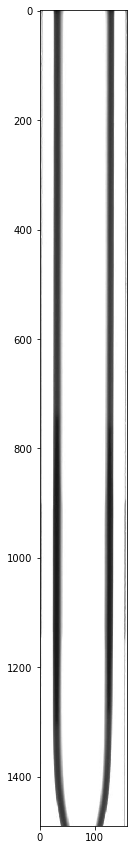

In [2]:
# Data import locations
param_path =  # USER DEFINED PATH TO PARAMETER CSV FILE, e.g., param_path = 'C:/Users/data.csv'
img_path =  # USER DEFINED PATH TO FOLDER OF DROPLET IMAGES, e.g., img_path = 'C:/Users/folder'

# Computer vision variables
double_watershed = True # True TO RUN TWO-FOLD WATERSHED SEGMENTATION, False TO RUN ONE-FOLD WATERSHED SEGMENTATION
max_droplets = 200 # USER DEFINED ESTIMATED MAX NUMBER OF DROPLETS PER ANY GIVEN IMAGE
large_element_pixels = 5000 # You may have to increase or decrease this number. Segmented objects that have more than this number of specified pixels are removed. To remove artefacting, decrease this number. To fix incorrectly removed droplets, increase this number.

# Bayesian Optimization prediction variables
BO_acquisition = 'EI' # SELECT FROM ['EI', 'MPI', 'LCB'] ACQUISITION FUNCTIONS
batch_size = 10 # SELECT NUMBER OF PREDICTIONS TO MAKE
save_predictions = True # True TO SAVE CSV OF PREDICTED NORMALIZED PARAMETER VALUES TO "param_path" DIRECTORY

# Variables for rotate/crop image
rotate_crop_params = {'theta': 0.5, 'x1': 920, 'x2': 1080, 'y1': 10, 'y2': 1500} # USER DEFINED ROTATE/CROP PARAMETERS

###################################
#########DO NOT EDIT BELOW#########
###################################
images = [im for im in listdir(img_path) if any(fmts in im for fmts in ['.jpg', '.png', '.jpeg'])] # grab list of image file names from img_path directory
# Plot one of the images from the directory using the selected "rotate_crop_params"
fig, ax = plt.subplots(figsize = (15,15))
plt.imshow(read_rotate_crop(img_path = img_path + '/' + images[0], rotate_crop_params = rotate_crop_params))

 ## Adjust rotation and crop parameters for your image
In the cell above, change the values of 'theta', 'x1', 'x2', 'y1', and 'y2' to rotate and crop the dorplet flow. Minimizing the number of all non-droplet objects in the image will improve the performance of the computer vision algorithm.

*The example below shows you how to crop your droplet image*

![crop](https://i.imgur.com/T91pRdz.jpg)

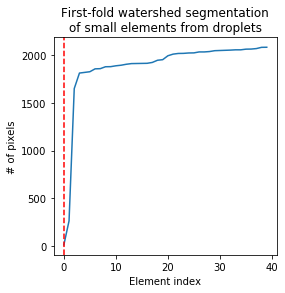

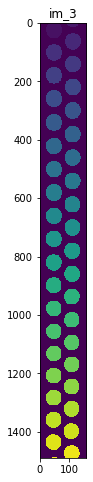

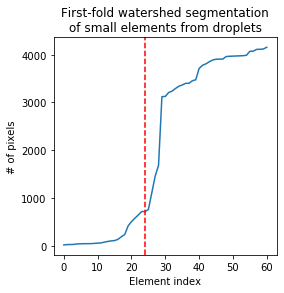

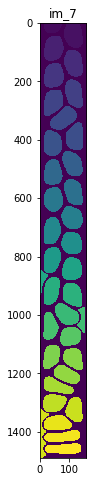

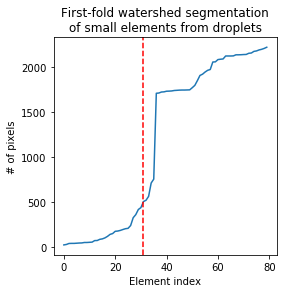

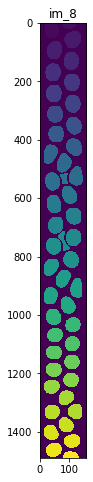

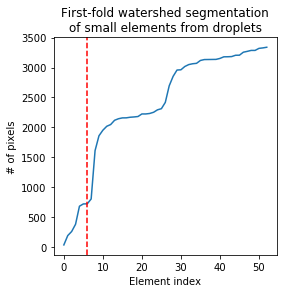

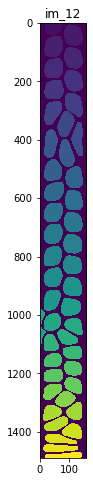

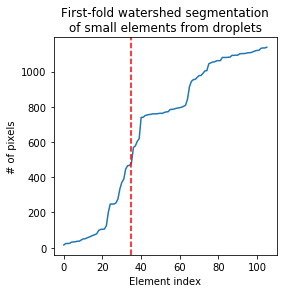

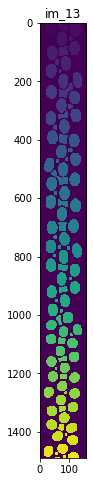

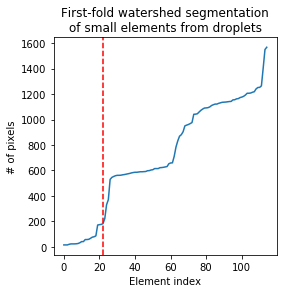

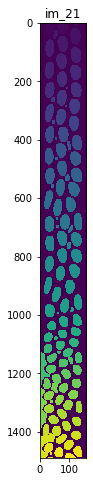

PREDICTED PARAMETER VALUES FOR BATCH SIZE = 10.


,Prediction,Param1,Param2
0,predicted_1,0.2985321872683395,1.0
1,predicted_2,0.30619240991797936,0.9496685952788899
2,predicted_3,0.2905102138732055,0.9138296743708704
3,predicted_4,0.2938787595205148,0.9747628711737831
4,predicted_5,0.32320782317641583,0.9994920800617015
5,predicted_6,0.2978478978359316,0.8751084822210856
6,predicted_7,0.28575509717006664,0.9277060045674483
7,predicted_8,0.27458245349968513,0.9914300599530114
8,predicted_9,0.29741591660576994,0.8408811234228318
9,predicted_10,0.30733762259682307,0.8896243182376907


In [3]:
# Build dataframe to store images and parameter data
data = pd.read_csv(param_path) # read parameter csv file into df
images_crop = [read_rotate_crop(img_path = img_path + '/' + im, rotate_crop_params = rotate_crop_params) for im in images] # create array of cropped droplet images
arrays = pd.DataFrame([im.split('.')[0] for im in images], columns = ['Image']) # create array with images in order of python-sorted image names
arrays['ImageArray'] = images_crop # concatenate image arrays to df in order of python-sorted image names
data = data.merge(arrays, how = 'left', left_on = 'Image', right_on = 'Image') # merge image arrays with parameter data in order of parameter data, keeping only images with names listed in "Image" column of parameter csv
data['TotalLoss'] = 1. # initialize all to have maximum loss before computing

# Compute the computer vision loss values for each image
for n in range(data.shape[0]):
    if not data.Failed[n]:
        droplet_count = watershed_segment(image=data.ImageArray[n], double_watershed=double_watershed, large_elements_pixels=large_element_pixels, pixel_diff=large_element_pixels/10,drop_dilate=5, plot_pixel_diff=True, remove_artefacting=False)
        
        plt.figure(figsize=(8,8))
        plt.imshow(droplet_count)
        plt.title(f'{data.Image[n]}')
        plt.show()
        
        yld_loss = yield_loss(droplet_count=droplet_count, max_droplets=max_droplets)
        geom_loss, droplet_geometry = geometric_loss(droplet_count=droplet_count, image_name=data.Image[n], iter_plot = False)
        total_loss = (yld_loss + geom_loss) / 2

        data.TotalLoss[data.Image == data.Image[n]] = total_loss
        
# Run Bayesian Optimization
print(f'PREDICTED PARAMETER VALUES FOR BATCH SIZE = {batch_size}.')
BO_optimizer(data = data, batch_size = batch_size, param_path = param_path, save = save_predictions) # Run BO and show prediction